<a href="https://colab.research.google.com/github/M22AIE212/MajorProject_SpeechUnderstanding/blob/main/Speech_Undertsanding_Major_Project_EER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/M22AIE212/MajorProject_SpeechUnderstanding.git

Cloning into 'MajorProject_SpeechUnderstanding'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 39 (delta 14), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (39/39), 369.85 KiB | 6.38 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp "/content/drive/MyDrive/Speech Understanding/A3/test-gram.zip" /content

In [6]:
!unzip /content/test-gram.zip

Archive:  /content/test-gram.zip
   creating: content/LibriSpeech/test-gram/
   creating: content/LibriSpeech/test-gram/1/
  inflating: content/LibriSpeech/test-gram/1/09e69cbb2d6a4329a1c4cbe23296abcc.png  
  inflating: content/LibriSpeech/test-gram/1/aeaef88aaddd4a7fa1b5d29f0da68b65.png  
  inflating: content/LibriSpeech/test-gram/1/346b087e6c8a427ea78774164644bb15.png  
  inflating: content/LibriSpeech/test-gram/1/62660c1efef94f75b82cf1d2dda07481.png  
  inflating: content/LibriSpeech/test-gram/1/aef40bb89cb24f2f9be00b502053725a.png  
  inflating: content/LibriSpeech/test-gram/1/ccb6645e29fd4d308d0a8b2151ced3a0.png  
  inflating: content/LibriSpeech/test-gram/1/1e2dd4140d2049ca87b6ba59c3727500.png  
  inflating: content/LibriSpeech/test-gram/1/4e8c9d4679d743b0bbde0b32eb108cdc.png  
  inflating: content/LibriSpeech/test-gram/1/fa134946412148bd8ad50d7b7cf051fa.png  
  inflating: content/LibriSpeech/test-gram/1/e9887e39f9ba45fb9403f36ee3f5e202.png  
  inflating: content/LibriSpeech/test

## Evaluation

In [7]:
%matplotlib inline
import os
import sys
sys.path.append("/content/MajorProject_SpeechUnderstanding")
import numpy as np
import random
import matplotlib.pyplot as plt
from time import time

import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils

import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

from utils import imshow,show_plot,plotting,Config
from custom_dataset import CustomDataset
from model import SiameseNetwork
from loss import CustomCrossEntropyLoss
from train import train_model
from eval import evaluate_model


print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

if __name__ =="__main__" :

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  trained_model_path = '/content/drive/MyDrive/Speech Understanding/A3/siamese_net_crossEntropy.pt'

  ## Train and Test Datasets and Dataloaders

  folder_dataset_test = dataset.ImageFolder(root="/content/content/LibriSpeech/test-gram")
  test_dataset = CustomDataset(imageFolderDataset=folder_dataset_test,
                                          transform=transforms.Compose([#transforms.Resize((100,100)),
                                                                        transforms.ToTensor()
                                                                        ])
                                        ,should_invert=False)

  test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

  ## Model , Loss and Optimizer Initialization
  model = SiameseNetwork().to(device)
  model.load_state_dict(torch.load(trained_model_path,map_location=torch.device('cpu')))


Version 2.2.1+cu121
CUDA enabled: False


In [52]:
from tqdm import tqdm
import torch.nn as nn
model_scores = []
target_label_list = []
model_preds = []
with torch.no_grad():
    for batch_idx, (input_data0, input_data1, target_label) in enumerate(tqdm(test_dataloader)):
        input_data0, input_data1, target_label = input_data0.to(device), input_data1.to(device), target_label.to(device)
        model_output = model(input_data0, input_data1)
        model_scores.extend(model_output[:,1].numpy())
        model_preds.extend(list(torch.argmax(model_output, dim=1).numpy()))
        target_label_list.extend(list(target_label.numpy()))

100%|██████████| 3/3 [00:28<00:00,  9.43s/it]


In [53]:
from sklearn.metrics import det_curve,RocCurveDisplay,auc,roc_curve,confusion_matrix

## EER
def compute_eer(truth, scores):
  frr, far, th = det_curve(truth, scores)
  abs_diffs = np.abs(frr - far)
  min_index = np.argmin(abs_diffs)
  eer = np.mean((frr[min_index], far[min_index]))
  return eer


## ROC - AUC
def plot_roc_curve_with_auc(truth, scores):
  fpr, tpr, thresholds = roc_curve(truth,scores)
  roc_auc = auc(fpr, tpr)
  display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
  display.plot()
  plt.title("ROC curve with AUC score : ")
  plt.show()

In [54]:
compute_eer(target_label_list,model_scores)

0.22410909929650558

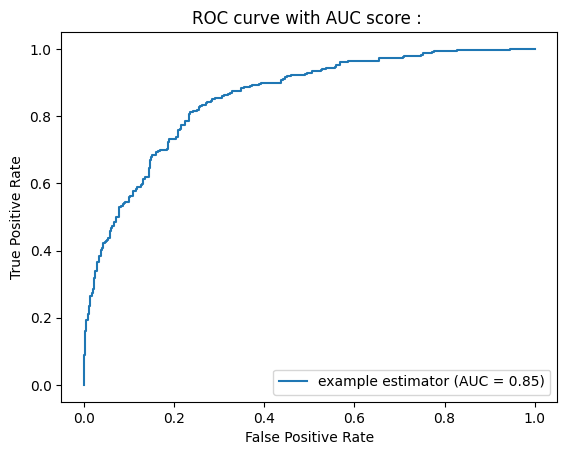

In [55]:
plot_roc_curve_with_auc(target_label_list,model_scores)

In [56]:
confusion_matrix(target_label_list,model_preds)

array([[327,  21],
       [144, 155]])